# 1. Carga de datos

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/house-prices-advanced-regression-techniques.zip'
extract_path = '/content/house_prices'

for file in os.listdir(extract_path):
    print(f"{file}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
best_final_model.pkl
submission.csv
train.csv
data_description.txt
test.csv
sample_submission.csv


In [3]:
train_path = '/content/house_prices/train.csv'
test_path = '/content/house_prices/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(f"Train: {train_df.shape[0]} filas, {train_df.shape[1]} columnas")
print(f"Test: {test_df.shape[0]} filas, {test_df.shape[1]} columnas")

print("\nVariable objetivo: 'SalePrice'")
print(f"Tipo: {train_df['SalePrice'].dtype}")
print(f"Rango: ${train_df['SalePrice'].min():,} - ${train_df['SalePrice'].max():,}")
print(f"Media: ${train_df['SalePrice'].mean():,.2f}")
print(f"Mediana: ${train_df['SalePrice'].median():,.2f}")

print("\nPrimeras 3 filas del dataset:")
display(train_df.head(3))

Train: 1460 filas, 81 columnas
Test: 1459 filas, 80 columnas

Variable objetivo: 'SalePrice'
Tipo: int64
Rango: $34,900 - $755,000
Media: $180,921.20
Mediana: $163,000.00

Primeras 3 filas del dataset:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


El dataset contiene 1,460 filas para entrenamiento y 1,459 para test, con 81 características. La variable objetivo SalePrice muestra un rango desde 34,900 hasta 755,000. La diferencia entre la media (180,921) y la mediana (163,000) indica una posible asimetría positiva en la distribución de precios.

En las primeras filas ya podemos observar valores nulos (NaN), lo que confirma la necesidad de realizar limpieza de datos

## Análisis de valores nulos y tipos de datos

In [4]:
# Valores nulos
missing_train = train_df.isnull().sum()
missing_percent = (missing_train / len(train_df) * 100)

# Crear DataFrame con columnas que tienen nulos
missing_df = pd.DataFrame({
    'Valores_Nulos': missing_train,
    'Porcentaje_Nulos': missing_percent
})

# Filtrar solo columnas con nulos y ordenar
missing_df = missing_df[missing_df['Valores_Nulos'] > 0].sort_values('Porcentaje_Nulos', ascending=False)

print(f"Columnas con valores nulos: {len(missing_df)} de {train_df.shape[1]}")
print("\nTop 15 columnas con más valores nulos:")
display(missing_df.head(15))

# Tipos de datos
dtype_counts = train_df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"{str(dtype):<10} : {count:3d} columnas")

# Separar columnas numéricas y categóricas
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNuméricas: {len(numeric_cols)} columnas")
print(f"Categóricas: {len(categorical_cols)} columnas")

Columnas con valores nulos: 19 de 81

Top 15 columnas con más valores nulos:


,Valores_Nulos,Porcentaje_Nulos
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


object     :  43 columnas
int64      :  35 columnas
float64    :   3 columnas

Numéricas: 38 columnas
Categóricas: 43 columnas


Hay 19 columnas con valores nulos de las 81 totales. Cuatro características (PoolQC, MiscFeature, Alley, Fence) tienen más del 80% de valores faltantes (alomejor podrían eliminarse del análisis).

La distribución de tipos de datos muestra 43 variables categóricas y 38 numéricas.

## Variable objetivo

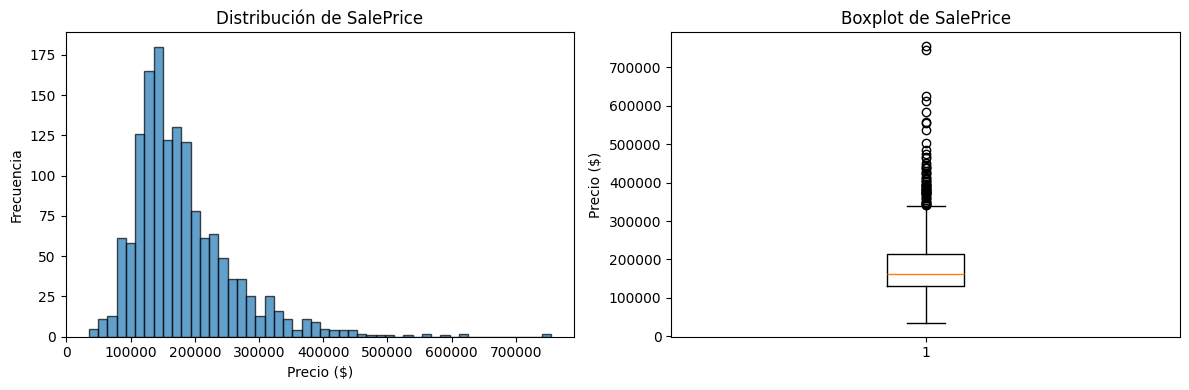

Estadísticas:
  Media               :       180921.20
  Mediana             :       163000.00
  Std                 :        79442.50
  Asimetría (Skew)    :            1.88
  Curtosis            :            6.54
  Mínimo              :        34900.00
  Máximo              :       755000.00
  Percentil 25        :       129975.00
  Percentil 75        :       214000.00

Top 15 correlaciones POSITIVAS más fuertes:
   1. OverallQual              : 0.791
   2. GrLivArea                : 0.709
   3. GarageCars               : 0.640
   4. GarageArea               : 0.623
   5. TotalBsmtSF              : 0.614
   6. 1stFlrSF                 : 0.606
   7. FullBath                 : 0.561
   8. TotRmsAbvGrd             : 0.534
   9. YearBuilt                : 0.523
  10. YearRemodAdd             : 0.507
  11. GarageYrBlt              : 0.486
  12. MasVnrArea               : 0.477
  13. Fireplaces               : 0.467
  14. BsmtFinSF1               : 0.386
  15. LotFrontage              : 0.

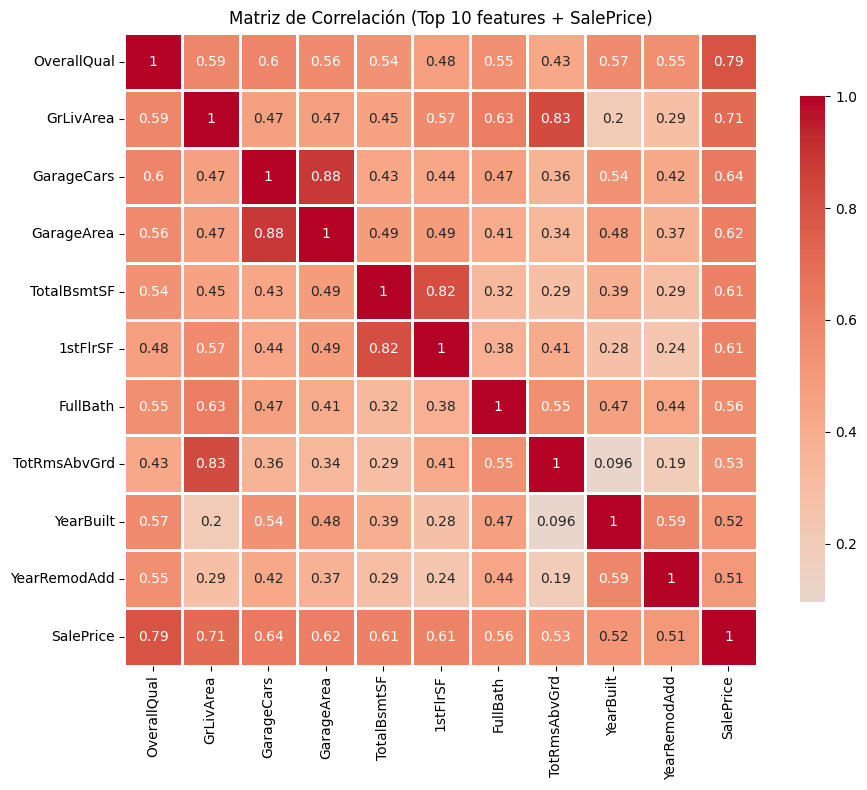


La variable más correlacionada es: 'OverallQual' (corr = 0.791)


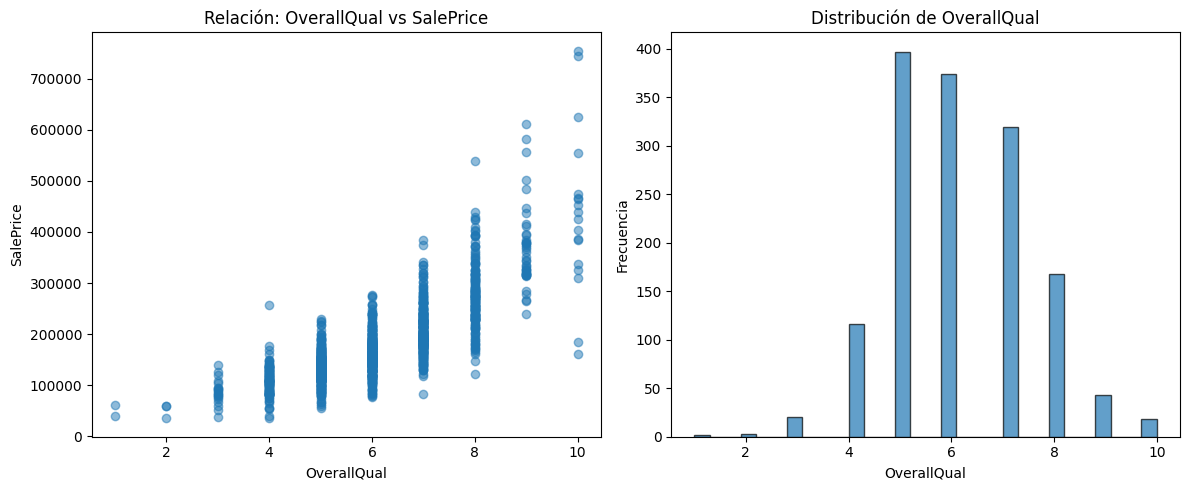

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograma
axes[0].hist(train_df['SalePrice'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución de SalePrice')
axes[0].set_xlabel('Precio ($)')
axes[0].set_ylabel('Frecuencia')

# Boxplot
axes[1].boxplot(train_df['SalePrice'])
axes[1].set_title('Boxplot de SalePrice')
axes[1].set_ylabel('Precio ($)')

plt.tight_layout()
plt.show()

# Estadísticas
stats_dict = {
    'Media': train_df['SalePrice'].mean(),
    'Mediana': train_df['SalePrice'].median(),
    'Std': train_df['SalePrice'].std(),
    'Asimetría (Skew)': train_df['SalePrice'].skew(),
    'Curtosis': train_df['SalePrice'].kurtosis(),
    'Mínimo': train_df['SalePrice'].min(),
    'Máximo': train_df['SalePrice'].max(),
    'Percentil 25': train_df['SalePrice'].quantile(0.25),
    'Percentil 75': train_df['SalePrice'].quantile(0.75)
}

print("Estadísticas:")
for key, value in stats_dict.items():
    print(f"  {key:<20}: {value:>15,.2f}" if 'Precio' in key else f"  {key:<20}: {value:>15.2f}")

# Correlaciones
correlations = train_df.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)

# Top 15 positivas y top 5 negativas
print("\nTop 15 correlaciones POSITIVAS más fuertes:")
for i, (col, corr) in enumerate(correlations[1:16].items(), 1):  # Excluye SalePrice misma
    print(f"  {i:2d}. {col:<25}: {corr:.3f}")

print("\nTop 5 correlaciones NEGATIVAS más fuertes:")
for i, (col, corr) in enumerate(correlations[-5:].items(), 1):
    print(f"  {i:2d}. {col:<25}: {corr:.3f}")

# Gráfico de correlaciones top 10
top_corr_features = correlations.index[1:11]

# Matriz de correlación para top features
corr_matrix = train_df[top_corr_features.tolist() + ['SalePrice']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación (Top 10 features + SalePrice)')
plt.tight_layout()
plt.show()

# Relación con la variable más correlacionada
most_corr_feature = correlations.index[1]
most_corr_value = correlations.iloc[1]

print(f"\nLa variable más correlacionada es: '{most_corr_feature}' (corr = {most_corr_value:.3f})")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(train_df[most_corr_feature], train_df['SalePrice'], alpha=0.5)
axes[0].set_xlabel(most_corr_feature)
axes[0].set_ylabel('SalePrice')
axes[0].set_title(f'Relación: {most_corr_feature} vs SalePrice')

if train_df[most_corr_feature].dtype == 'object':
    axes[1].boxplot([train_df[train_df[most_corr_feature] == val]['SalePrice'].dropna()
                    for val in train_df[most_corr_feature].dropna().unique()[:10]])
    axes[1].set_xlabel(most_corr_feature)
    axes[1].set_ylabel('SalePrice')
    axes[1].set_title('Distribución por categoría')
else:
    axes[1].hist(train_df[most_corr_feature].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel(most_corr_feature)
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title(f'Distribución de {most_corr_feature}')

plt.tight_layout()
plt.show()

La distribución de SalePrice confirma asimetría positiva (skew = 1.88), con cola hacia valores altos. La alta curtosis (6.54) indica presencia de outliers extremos, visibles en el boxplot.

OverallQual muestra la correlación más fuerte (0.791), seguida por GrLivArea (0.709) y GarageCars (0.640). Estas variables relacionadas con calidad, área habitable y garajes son predictores clave para el precio.

Las correlaciones negativas son débiles, siendo KitchenAbvGr (-0.136) la más relevante, sugiriendo que cocinas en pisos superiores pueden disminuir el valor. La fuerte correlación con características de calidad y tamaño tiene bastante sentido.

# 2. Preprocesamiento

In [6]:
train_clean = train_df.copy()
test_clean = test_df.copy()

train_ids = train_clean['Id']
test_ids = test_clean['Id']

train_clean = train_clean.drop('Id', axis=1)
test_clean = test_clean.drop('Id', axis=1)

y = train_clean['SalePrice']
X = train_clean.drop('SalePrice', axis=1)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Test shape: {test_clean.shape}")

# Columnas con >80% de valores nulos
high_missing_cols = missing_df[missing_df['Porcentaje_Nulos'] > 80].index.tolist()
print(f"\nEliminar columnas con >80% nulos ({len(high_missing_cols)}):")
for col in high_missing_cols:
    print(f"  - {col}: {missing_df.loc[col, 'Porcentaje_Nulos']:.1f}% nulos")

# Columnas categóricas con pocos nulos (moda)
cat_cols = X.select_dtypes(include=['object']).columns
cat_cols_with_null = [col for col in cat_cols if col in missing_df.index and col not in high_missing_cols]

print(f"\nCategóricas a imputar con moda ({len(cat_cols_with_null)}):")
for col in cat_cols_with_null[:10]:
    print(f"  - {col}: {missing_df.loc[col, 'Valores_Nulos']} nulos")

# Columnas numéricas con pocos nulos (mediana)
num_cols = X.select_dtypes(include=[np.number]).columns
num_cols_with_null = [col for col in num_cols if col in missing_df.index and col not in high_missing_cols]

print(f"\nNuméricas a imputar con mediana ({len(num_cols_with_null)}):")
for col in num_cols_with_null:
    print(f"  - {col}: {missing_df.loc[col, 'Valores_Nulos']} nulos")

# Eliminar columnas con muchos nulos
X_clean = X.drop(high_missing_cols, axis=1)
test_clean_reduced = test_clean.drop(high_missing_cols, axis=1)

print(f"Columnas eliminadas: {len(high_missing_cols)}")
print(f"Nuevo shape X: {X_clean.shape}")
print(f"Nuevo shape test: {test_clean_reduced.shape}")

cat_cols_clean = X_clean.select_dtypes(include=['object']).columns
num_cols_clean = X_clean.select_dtypes(include=[np.number]).columns

# Valores nulos restantes
remaining_nulls = X_clean.isnull().sum()
remaining_nulls = remaining_nulls[remaining_nulls > 0]
print(f"Columnas con nulos restantes: {len(remaining_nulls)}")

if len(remaining_nulls) > 0:
    for col, count in remaining_nulls.head(10).items():
        print(f"  - {col}: {count} nulos ({count/len(X_clean)*100:.1f}%)")


print(f"Columnas originales: {train_df.shape[1]}")
print(f"Columnas después de eliminar: {X_clean.shape[1] + 1} (+ SalePrice)")
print(f"Columnas eliminadas: {len(high_missing_cols)}")
print(f"Valores nulos originales en train: {train_df.isnull().sum().sum()}")
print(f"Valores nulos actuales en X: {X_clean.isnull().sum().sum()}")

X shape: (1460, 79), y shape: (1460,)
Test shape: (1459, 79)

Eliminar columnas con >80% nulos (4):
  - PoolQC: 99.5% nulos
  - MiscFeature: 96.3% nulos
  - Alley: 93.8% nulos
  - Fence: 80.8% nulos

Categóricas a imputar con moda (12):
  - MasVnrType: 872 nulos
  - BsmtQual: 37 nulos
  - BsmtCond: 37 nulos
  - BsmtExposure: 38 nulos
  - BsmtFinType1: 37 nulos
  - BsmtFinType2: 38 nulos
  - Electrical: 1 nulos
  - FireplaceQu: 690 nulos
  - GarageType: 81 nulos
  - GarageFinish: 81 nulos

Numéricas a imputar con mediana (3):
  - LotFrontage: 259 nulos
  - MasVnrArea: 8 nulos
  - GarageYrBlt: 81 nulos
Columnas eliminadas: 4
Nuevo shape X: (1460, 75)
Nuevo shape test: (1459, 75)
Columnas con nulos restantes: 15
  - LotFrontage: 259 nulos (17.7%)
  - MasVnrType: 872 nulos (59.7%)
  - MasVnrArea: 8 nulos (0.5%)
  - BsmtQual: 37 nulos (2.5%)
  - BsmtCond: 37 nulos (2.5%)
  - BsmtExposure: 38 nulos (2.6%)
  - BsmtFinType1: 37 nulos (2.5%)
  - BsmtFinType2: 38 nulos (2.6%)
  - Electrical: 1 n

Se eliminan 4 columnas con más del 80% de valores nulos (PoolQC, MiscFeature, Alley, Fence), ya que contienen información insuficiente para imputación confiable. Se reduce el dataset de 81 a 76 columnas, manteniendo la variable objetivo.

Quedan 15 columnas con valores nulos para imputar: 12 categóricas (a imputar con moda) y 3 numéricas (a imputar con mediana). Los valores nulos han disminuido de 7,829 a 2,422, un 69%. Las columnas con mayor proporción de nulos restantes son MasVnrType (59.7%) y LotFrontage (17.7%).

Imputación de valores nulos

Columnas categóricas: 39
Columnas numéricas: 36
Valores nulos en X_imputed: 0
Valores nulos en test_imputed: 0


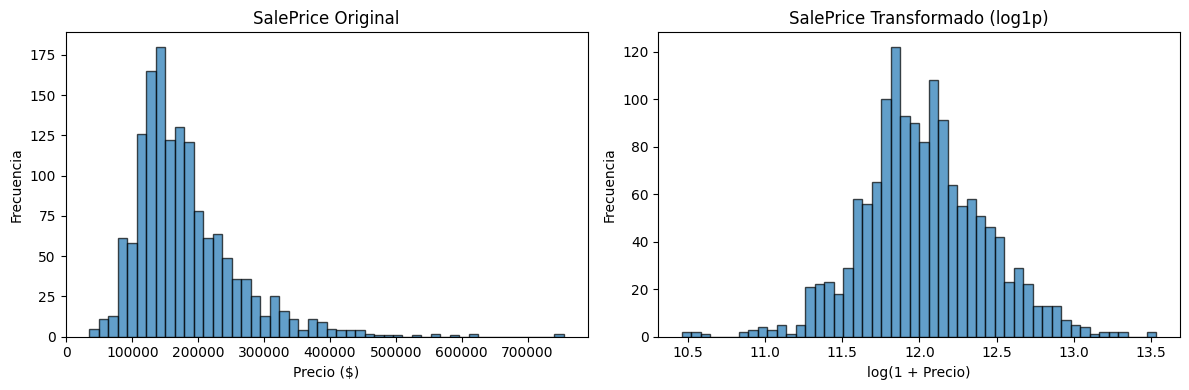

Comparación de asimetría (skewness):
Original: 1.883
Transformado: 0.121
Columnas categóricas originales: 39
Columnas después de One-Hot Encoding: 238
Ejemplos de nuevas columnas: ['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM']...
X_final shape: (1460, 274)
test_final shape: (1459, 274)
y_log shape: (1460,)


In [7]:
cat_cols_current = X_clean.select_dtypes(include=['object']).columns
num_cols_current = X_clean.select_dtypes(include=[np.number]).columns

print(f"Columnas categóricas: {len(cat_cols_current)}")
print(f"Columnas numéricas: {len(num_cols_current)}")

# Imputadores
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')

# Categoricas
X_cat_imputed = cat_imputer.fit_transform(X_clean[cat_cols_current])
test_cat_imputed = cat_imputer.transform(test_clean_reduced[cat_cols_current])

# Numericas
X_num_imputed = num_imputer.fit_transform(X_clean[num_cols_current])
test_num_imputed = num_imputer.transform(test_clean_reduced[num_cols_current])

X_cat_df = pd.DataFrame(X_cat_imputed, columns=cat_cols_current, index=X_clean.index)
X_num_df = pd.DataFrame(X_num_imputed, columns=num_cols_current, index=X_clean.index)

test_cat_df = pd.DataFrame(test_cat_imputed, columns=cat_cols_current, index=test_clean_reduced.index)
test_num_df = pd.DataFrame(test_num_imputed, columns=num_cols_current, index=test_clean_reduced.index)

X_imputed = pd.concat([X_num_df, X_cat_df], axis=1)
test_imputed = pd.concat([test_num_df, test_cat_df], axis=1)

print(f"Valores nulos en X_imputed: {X_imputed.isnull().sum().sum()}")
print(f"Valores nulos en test_imputed: {test_imputed.isnull().sum().sum()}")

# Transformación de la variable objetivo
y_log = np.log1p(y)  # log(1 + y) para manejar ceros

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Antes
axes[0].hist(y, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('SalePrice Original')
axes[0].set_xlabel('Precio ($)')
axes[0].set_ylabel('Frecuencia')

# Después
axes[1].hist(y_log, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_title('SalePrice Transformado (log1p)')
axes[1].set_xlabel('log(1 + Precio)')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

print("Comparación de asimetría (skewness):")
print(f"Original: {y.skew():.3f}")
print(f"Transformado: {y_log.skew():.3f}")

# Codificación de variables categóricas
# OneHotEncoding para categóricas
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_cat_encoded = ohe.fit_transform(X_imputed[cat_cols_current])
X_num = X_imputed[num_cols_current].values

test_cat_encoded = ohe.transform(test_imputed[cat_cols_current])
test_num = test_imputed[num_cols_current].values

cat_encoded_cols = []
for i, col in enumerate(cat_cols_current):
    for category in ohe.categories_[i]:
        cat_encoded_cols.append(f"{col}_{category}")

print(f"Columnas categóricas originales: {len(cat_cols_current)}")
print(f"Columnas después de One-Hot Encoding: {len(cat_encoded_cols)}")
print(f"Ejemplos de nuevas columnas: {cat_encoded_cols[:5]}...")

# 5. Combinar features numéricas y codificadas
X_final = np.hstack([X_num, X_cat_encoded])
test_final = np.hstack([test_num, test_cat_encoded])

print(f"X_final shape: {X_final.shape}")
print(f"test_final shape: {test_final.shape}")
print(f"y_log shape: {y_log.shape}")

# Estandarización de features numéricas
scaler = StandardScaler()

num_cols_count = len(num_cols_current)

# train
X_final_scaled = X_final.copy()
X_final_scaled[:, :num_cols_count] = scaler.fit_transform(X_final[:, :num_cols_count])

# test
test_final_scaled = test_final.copy()
test_final_scaled[:, :num_cols_count] = scaler.transform(test_final[:, :num_cols_count])

Se eliminan todos los valores nulos. La transformación logarítmica de SalePrice reduce la asimetría de 1.883 a 0.121, normalizando la distribución para mejor rendimiento del modelo.

Se aplica One-Hot Encoding a 39 variables categóricas, expandiéndolas a 238 columnas binarias. El dataset final contiene 274 features (36 numéricas + 238 codificadas), todas estandarizadas (variables numéricas con media 0 y desviación estándar 1)

# 3. Regresion

Train: 1168 muestras
Validation: 292 muestras
Test (original): 1459 muestras

Linear Regression:
  RMSE: $22,909.08
  MAE: $15,069.92
  R²: 0.9316
  RMSE (log scale): 0.1290

Ridge (alpha=1.0):
  RMSE: $23,645.81
  MAE: $15,708.61
  R²: 0.9271
  RMSE (log scale): 0.1277

Lasso (alpha=0.01):
  RMSE: $31,461.06
  MAE: $19,495.93
  R²: 0.8710
  RMSE (log scale): 0.1570

Random Forest:
  RMSE: $28,589.91
  MAE: $17,435.69
  R²: 0.8934
  RMSE (log scale): 0.1445

Gradient Boosting:
  RMSE: $30,012.27
  MAE: $16,964.44
  R²: 0.8826
  RMSE (log scale): 0.1377


,Model,RMSE,MAE,R²,RMSE_log
0,Linear Regression,22909.076506,15069.917744,0.931577,0.128956
1,Ridge (alpha=1.0),23645.806697,15708.614655,0.927106,0.127725
3,Random Forest,28589.911327,17435.688844,0.893436,0.144467
4,Gradient Boosting,30012.268906,16964.438942,0.882569,0.137718
2,Lasso (alpha=0.01),31461.057369,19495.934323,0.870957,0.156992


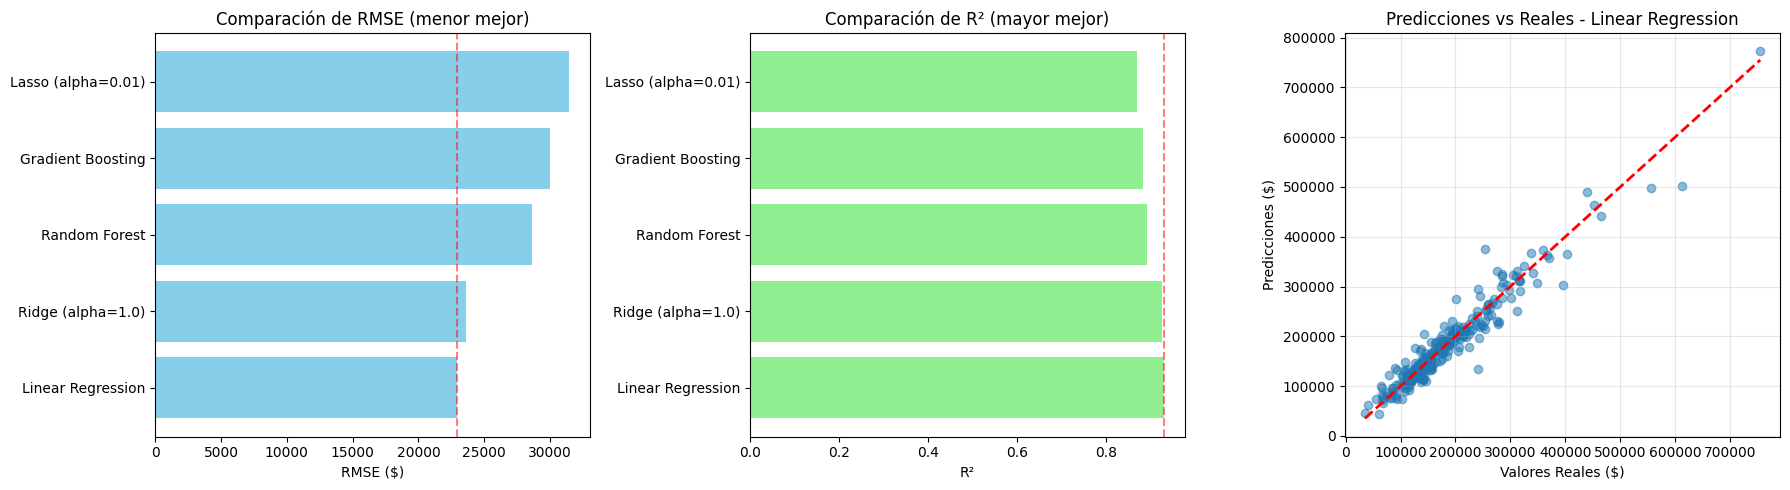

LinearRegression()

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X_final_scaled, y_log, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape[0]} muestras")
print(f"Validation: {X_val.shape[0]} muestras")
print(f"Test (original): {test_final_scaled.shape[0]} muestras")

models = {
    'Linear Regression': LinearRegression(),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0, random_state=42),
    'Lasso (alpha=0.01)': Lasso(alpha=0.01, random_state=42, max_iter=10000),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Entrenar y evaluar modelos
results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    y_val_original = np.expm1(y_val)
    y_pred_original = np.expm1(y_pred)

    # Calcular métricas
    mse = mean_squared_error(y_val_original, y_pred_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val_original, y_pred_original)
    r2 = r2_score(y_val_original, y_pred_original)

    mse_log = mean_squared_error(y_val, y_pred)
    rmse_log = np.sqrt(mse_log)

    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'RMSE_log': rmse_log
    })

    print(f"\n{name}:")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE: ${mae:,.2f}")
    print(f"  R²: {r2:.4f}")
    print(f"  RMSE (log scale): {rmse_log:.4f}")

results_df = pd.DataFrame(results).sort_values('RMSE')
display(results_df)

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: RMSE comparativo
axes[0].barh(results_df['Model'], results_df['RMSE'], color='skyblue')
axes[0].set_xlabel('RMSE ($)')
axes[0].set_title('Comparación de RMSE (menor mejor)')
axes[0].axvline(x=results_df['RMSE'].min(), color='red', linestyle='--', alpha=0.5)

# Gráfico 2: R² comparativo
axes[1].barh(results_df['Model'], results_df['R²'], color='lightgreen')
axes[1].set_xlabel('R²')
axes[1].set_title('Comparación de R² (mayor mejor)')
axes[1].axvline(x=results_df['R²'].max(), color='red', linestyle='--', alpha=0.5)

# Gráfico 3: Predicciones vs valores reales
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_val)
y_pred_best_original = np.expm1(y_pred_best)

axes[2].scatter(y_val_original, y_pred_best_original, alpha=0.5)
axes[2].plot([y_val_original.min(), y_val_original.max()],
             [y_val_original.min(), y_val_original.max()],
             'r--', lw=2)
axes[2].set_xlabel('Valores Reales ($)')
axes[2].set_ylabel('Predicciones ($)')
axes[2].set_title(f'Predicciones vs Reales - {best_model_name}')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Entreno el mejor modelo con todos los datos de train
best_model.fit(X_final_scaled, y_log)

La Regresión lineal simple ha tenido el mejor resultado con un RMSE de $22,909 y un R² de 0.932, indicando que explica el 93.2% de la varianza en los precios. Su error absoluto medio (MAE) de 15,070 significa que las predicciones se desvían en promedio esta cantidad del precio real.

Ridge Regression muestra resultados ligeramente inferiores, mientras que Lasso tiene el peor rendimiento, posiblemente por eliminar características importantes. Los modelos ensemble (Random Forest y Gradient Boosting) no superan a la regresión lineal en este caso.